In [1]:
pip install -U scikit-tda

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 17.0 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=00df75e9a001b2932862520d8e357ca47da106d2868d8195e03a9ecd25fe23a8
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [2]:
#Do all of the imports and setup inline plotting
import numpy as np
from ripser import ripser

import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from scipy.interpolate import InterpolatedUnivariateSpline

from ripser import ripser
from persim import plot_diagrams

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

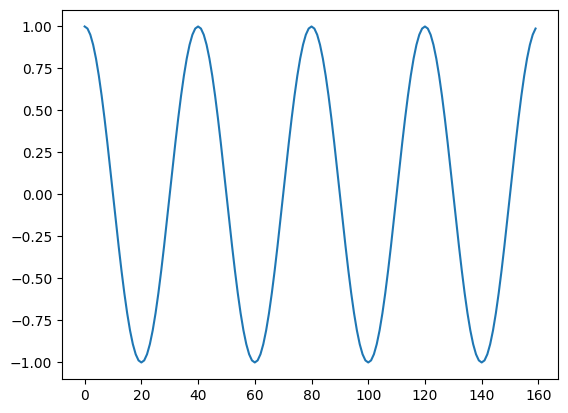

In [3]:
# Step 1: Setup the signal
T = 40 # The period in number of samples
NPeriods = 4 # How many periods to go through
N = T*NPeriods #The total number of samples
t = np.linspace(0, 2*np.pi*NPeriods, N+1)[:N] # Sampling indices in time
x = np.cos(t) # The final signal
plt.plot(x)

plt.show()

Here we define a custom sliding window function instead of relying on the Giotto-tda API.

In [4]:
def getSlidingWindow(x, dim, Tau, dT):
    """
    Return a sliding window of a time series,
    using arbitrary sampling.  Use linear interpolation
    to fill in values in windows not on the original grid
    Parameters
    ----------
    x: ndarray(N)
        The original time series
    dim: int
        Dimension of sliding window (number of lags+1)
    Tau: float
        Length between lags, in units of time series
    dT: float
        Length between windows, in units of time series
    Returns
    -------
    X: ndarray(N, dim)
        All sliding windows stacked up
    """
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim))
    spl = InterpolatedUnivariateSpline(np.arange(N), x)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        # Only take windows that are within range
        if end >= len(x):
            X = X[0:i, :]
            break
        X[i, :] = spl(idxx)
    return X

Here, you can play around with the choice of parameters and see how it effects the embedding.

For a fixed value of $\tau$, try to find dimensions for which the values of $\lambda_{1}$ and $\lambda_{2}$ are close to each other, i.e., $\lambda_{1} \sim \lambda_{2}$. What does the window size of the signal gives you in this case?

lambda1 = 4.98832, lambda2 = 4.96421


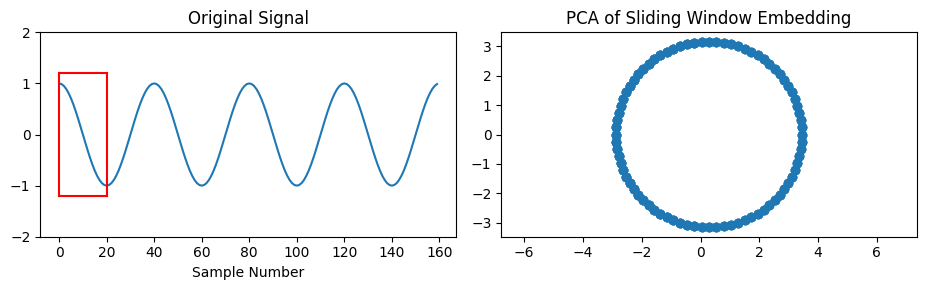

In [5]:
def on_value_change(change):
    execute_computation1()

dimslider = widgets.IntSlider(min=1,max=40,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=0.5,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider,dTslider)))

plt.figure(figsize=(9.5, 3))
def execute_computation1():
    plt.clf()
    # Step 1: Setup the signal again in case x was lost
    T = 40 # The period in number of samples
    NPeriods = 4 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t)  # The final signal

    # Get slider values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value

    #Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_
    print("lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

    #Step 4: Plot original signal and PCA of the embedding
    ax = plt.subplot(121)
    ax.plot(x)
    ax.set_ylim((-2*max(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')
    ax2 = plt.subplot(122)
    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.scatter(Y[:, 0], Y[:, 1])
    ax2.set_aspect('equal', 'datalim')
    plt.tight_layout()

execute_computation1()

Here, for a fixed $\tau = 1$, we look for the dimensions where the absolute value of the difference $\lambda_{1} - \lambda_{2}$ is minimal.

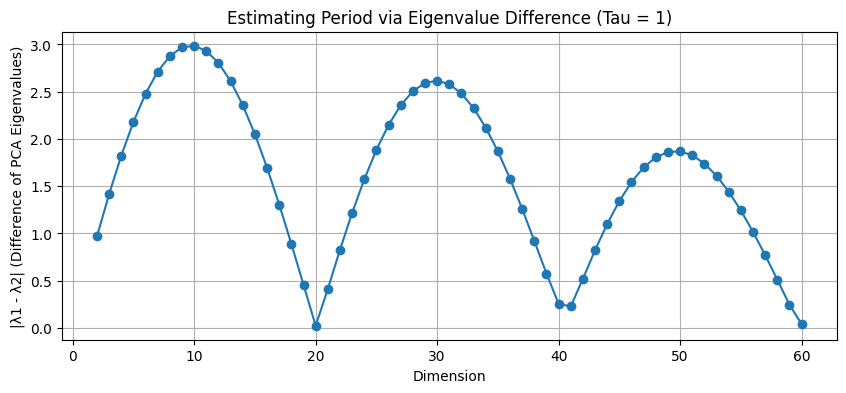

In [6]:
T = 40 # The period in number of samples
NPeriods = 4 # How many periods to go through
N = T*NPeriods # The total number of samples
t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
x = np.cos(t)  # The final signal

# Fixed Tau value
Tau = 1.0
dT = 0.5

# Sweep over dimensions
dim_values = np.arange(2, 61)
diffs = []

for dim in dim_values:
    X = getSlidingWindow(x, dim, Tau, dT)
    if X.shape[0] == 0 or X.shape[1] < 2:
        diffs.append(np.nan)
        continue
    pca = PCA(n_components=2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_
    diff = np.abs(eigs[0] - eigs[1])
    diffs.append(diff)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dim_values, diffs, marker='o')
plt.xlabel("Dimension")
plt.ylabel("|λ1 - λ2| (Difference of PCA Eigenvalues)")
plt.title("Estimating Period via Eigenvalue Difference (Tau = 1)")
plt.grid(True)
plt.show()

We repeat the steps above, this time with some noise.

lambda1 = 1.50539, lambda2 = 0.00345069


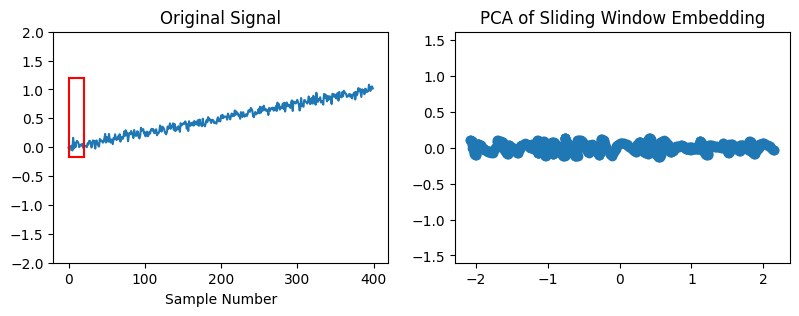

In [7]:
noise = 0.05*np.random.randn(400)

def on_value_change(change):
    execute_computation2()

dimslider = widgets.IntSlider(min=1,max=40,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description='Tau: ',continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=0.5,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider,dTslider)))

plt.figure(figsize=(9.5, 3))

def execute_computation2():
    plt.clf()
    # Step 1: Set up the signal
    x = np.arange(400)
    x = x/float(len(x))
    x = x + noise # Add some noise

    # Get slider values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value

    #Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_
    print("lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

    #Step 4: Plot original signal and PCA of the embedding
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    ax.set_ylim((-2, 2))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')
    ax2 = plt.subplot(gs[0, 1])
    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.scatter(Y[:, 0], Y[:, 1])
    ax2.set_aspect('equal', 'datalim')

execute_computation2()


Once more, this time we use PCA to visualize the embedding in $\mathbb{R}^{3}$ of the signal
\begin{equation}
f(t) = \cos(\omega t) + \cos(3\omega t)
\end{equation}

Play around with the embedding parameters but also the frequencies $T_{1}$ and $T_{2}$.

We say that two sinusoids are $\textit{harmonics}$ of each other if the ratio between the two is a rational number.
By contrast, if the ratio of the two frequencies is irrational, then the sinusoids are called $\textit{incommensurate}$.

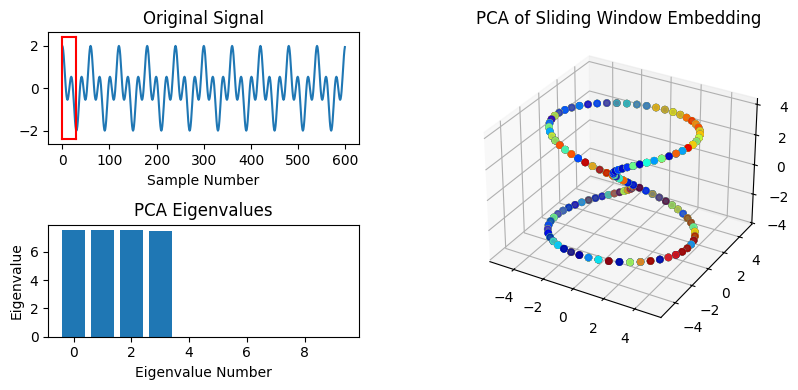

In [8]:
def on_value_change(change):
    execute_computation3()

embeddingdimbox = widgets.Dropdown(options=[2, 3],value=3,description='Embedding Dimension:',disabled=False)
embeddingdimbox.observe(on_value_change,names='value')

secondfreq = widgets.Dropdown(options=[2, 3, np.pi],value=3,description='Second Frequency:',disabled=False)
secondfreq.observe(on_value_change,names='value')

noiseampslider = widgets.FloatSlider(min=0,max=6,step=0.5,value=0,description='Noise Amplitude',continuous_update=False)
noiseampslider.observe(on_value_change, names='value')

dimslider = widgets.IntSlider(min=1,max=100,value=30,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description='Tau: ',continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=0.5,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( secondfreq,embeddingdimbox,noiseampslider)))
display(widgets.HBox((dimslider,Tauslider,dTslider)))

noise = np.random.randn(10000)

fig = plt.figure(figsize=(9.5, 4))
def execute_computation3():
    plt.clf()

    # Step 1: Setup the signal
    T1 = 20 # The period of the first cosine in number of samples
    T2 = T1*secondfreq.value # The period of the second cosine in number of samples
    NPeriods = 10 # How many periods to go through, relative to the second sinusoid
    N = T2*NPeriods # The total number of samples
    t = np.arange(N) # Time indices
    x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
    x += np.cos(2*np.pi*(1.0/T2)*t) # Add the second sinusoid
    x += noiseampslider.value*noise[:len(x)]

    # Get widget values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value
    embeddingdim = embeddingdimbox.value

    # Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    # Step 3: Perform PCA down to dimension chosen for visualization
    pca = PCA(n_components = 10)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Step 4: Plot original signal and PCA of the embedding
    gs = gridspec.GridSpec(2, 2,width_ratios=[1, 2])

    # Plot the signal
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")

    c = plt.get_cmap('jet')
    C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
    C = C[:, 0:3]

    # Plot the PCA embedding
    if embeddingdim == 3:
        ax2 = plt.subplot(gs[:,1],projection='3d')
        ax2.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
        ax2.set_aspect('equal', 'datalim')
    else:
        ax2 = plt.subplot(gs[:,1])
        ax2.scatter(Y[:, 0], Y[:, 1],c=C)

    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.set_aspect('equal', 'datalim')

    # Plot the eigenvalues as bars
    ax3 = plt.subplot(gs[1,0])
    eigs = eigs[0:min(len(eigs), 10)]
    ax3.bar(np.arange(len(eigs)), eigs)
    ax3.set_xlabel("Eigenvalue Number")
    ax3.set_ylabel("Eigenvalue")
    ax3.set_title("PCA Eigenvalues")

    plt.tight_layout()

    plt.show();

execute_computation3()

Changing the frequency in the second sinusoid, turning them from harmonic to noncommensurate, creates a marked change in the geometry. By contrast, the power spectral density functions are very close between the two, as shown below. Hence, it appears that geometric tools are more appropriate for telling the difference between these two types of signals.

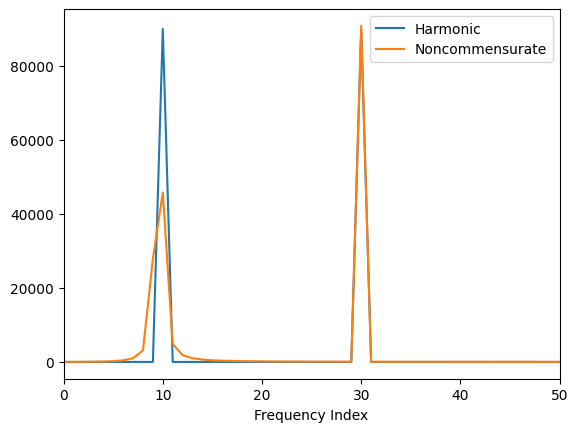

In [9]:
T = 20 #The period of the first sine in number of samples
NPeriods = 10 #How many periods to go through, relative to the faster sinusoid
N = T*NPeriods*3 #The total number of samples
t = np.arange(N) #Time indices

#Make the harmonic signal cos(t) + cos(3t)
xH = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(3*T)*t))

#Make the incommensurate signal cos(t) + cos(pi*t)
xNC = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(np.pi*T)*t))

plt.figure()
P1 = np.abs(np.fft.fft(xH))**2
P2 = np.abs(np.fft.fft(xNC))**2
plt.plot(np.arange(len(P1)), P1)
plt.plot(np.arange(len(P2)), P2)
plt.xlabel("Frequency Index")
plt.legend({"Harmonic", "Noncommensurate"})
plt.xlim([0, 50])
plt.show();

We can repeat the experiment once again, this time adding the computation of the persistence diagram.

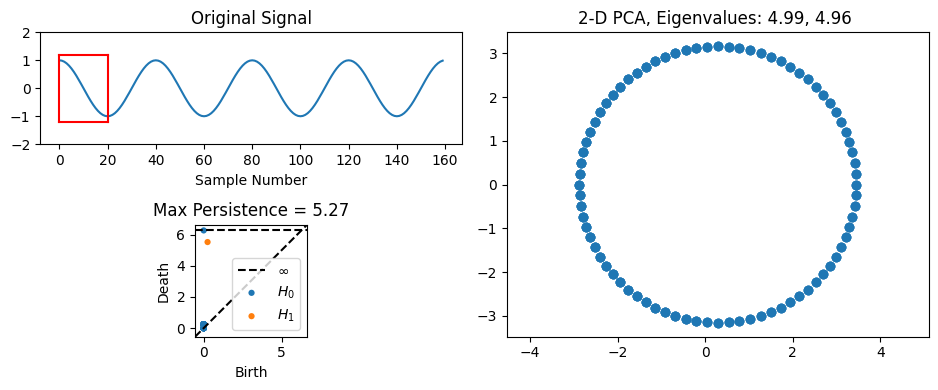

In [10]:
def on_value_change(change):
    execute_computation1()

dimslider = widgets.IntSlider(min=1,max=100,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')

noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=0,description='Noise Amplitude',continuous_update=False)
noiseampslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider, noiseampslider)))

noise = np.random.randn(10000)

fig = plt.figure(figsize=(9.5, 4))

def execute_computation4():
    plt.clf()
    # Step 1: Setup the signal
    T = 40 # The period in number of samples
    NPeriods = 4 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t) # The final signal
    x += noiseampslider.value * noise[:len(x)]

    # Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.5
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    # Step 3: Do Rips Filtration
    PDs = ripser(X, maxdim=1)['dgms']
    I = PDs[1]

    # Step 4: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Step 5: Plot original signal, 2-D projection, and the persistence diagram
    gs = gridspec.GridSpec(2, 2)
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    ax.set_ylim((2*min(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')

    ax2 = plt.subplot(gs[1,0])
    plot_diagrams(PDs)
    plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))

    ax3 = plt.subplot(gs[:,1])
    ax3.scatter(Y[:, 0], Y[:, 1])
    plt.axis('equal')
    plt.title("2-D PCA, Eigenvalues: %.3g, %.3g "%(eigs[0],eigs[1]))

    plt.tight_layout()

execute_computation4()

What is the effect of random noise on the embedding and its persistence diagram?

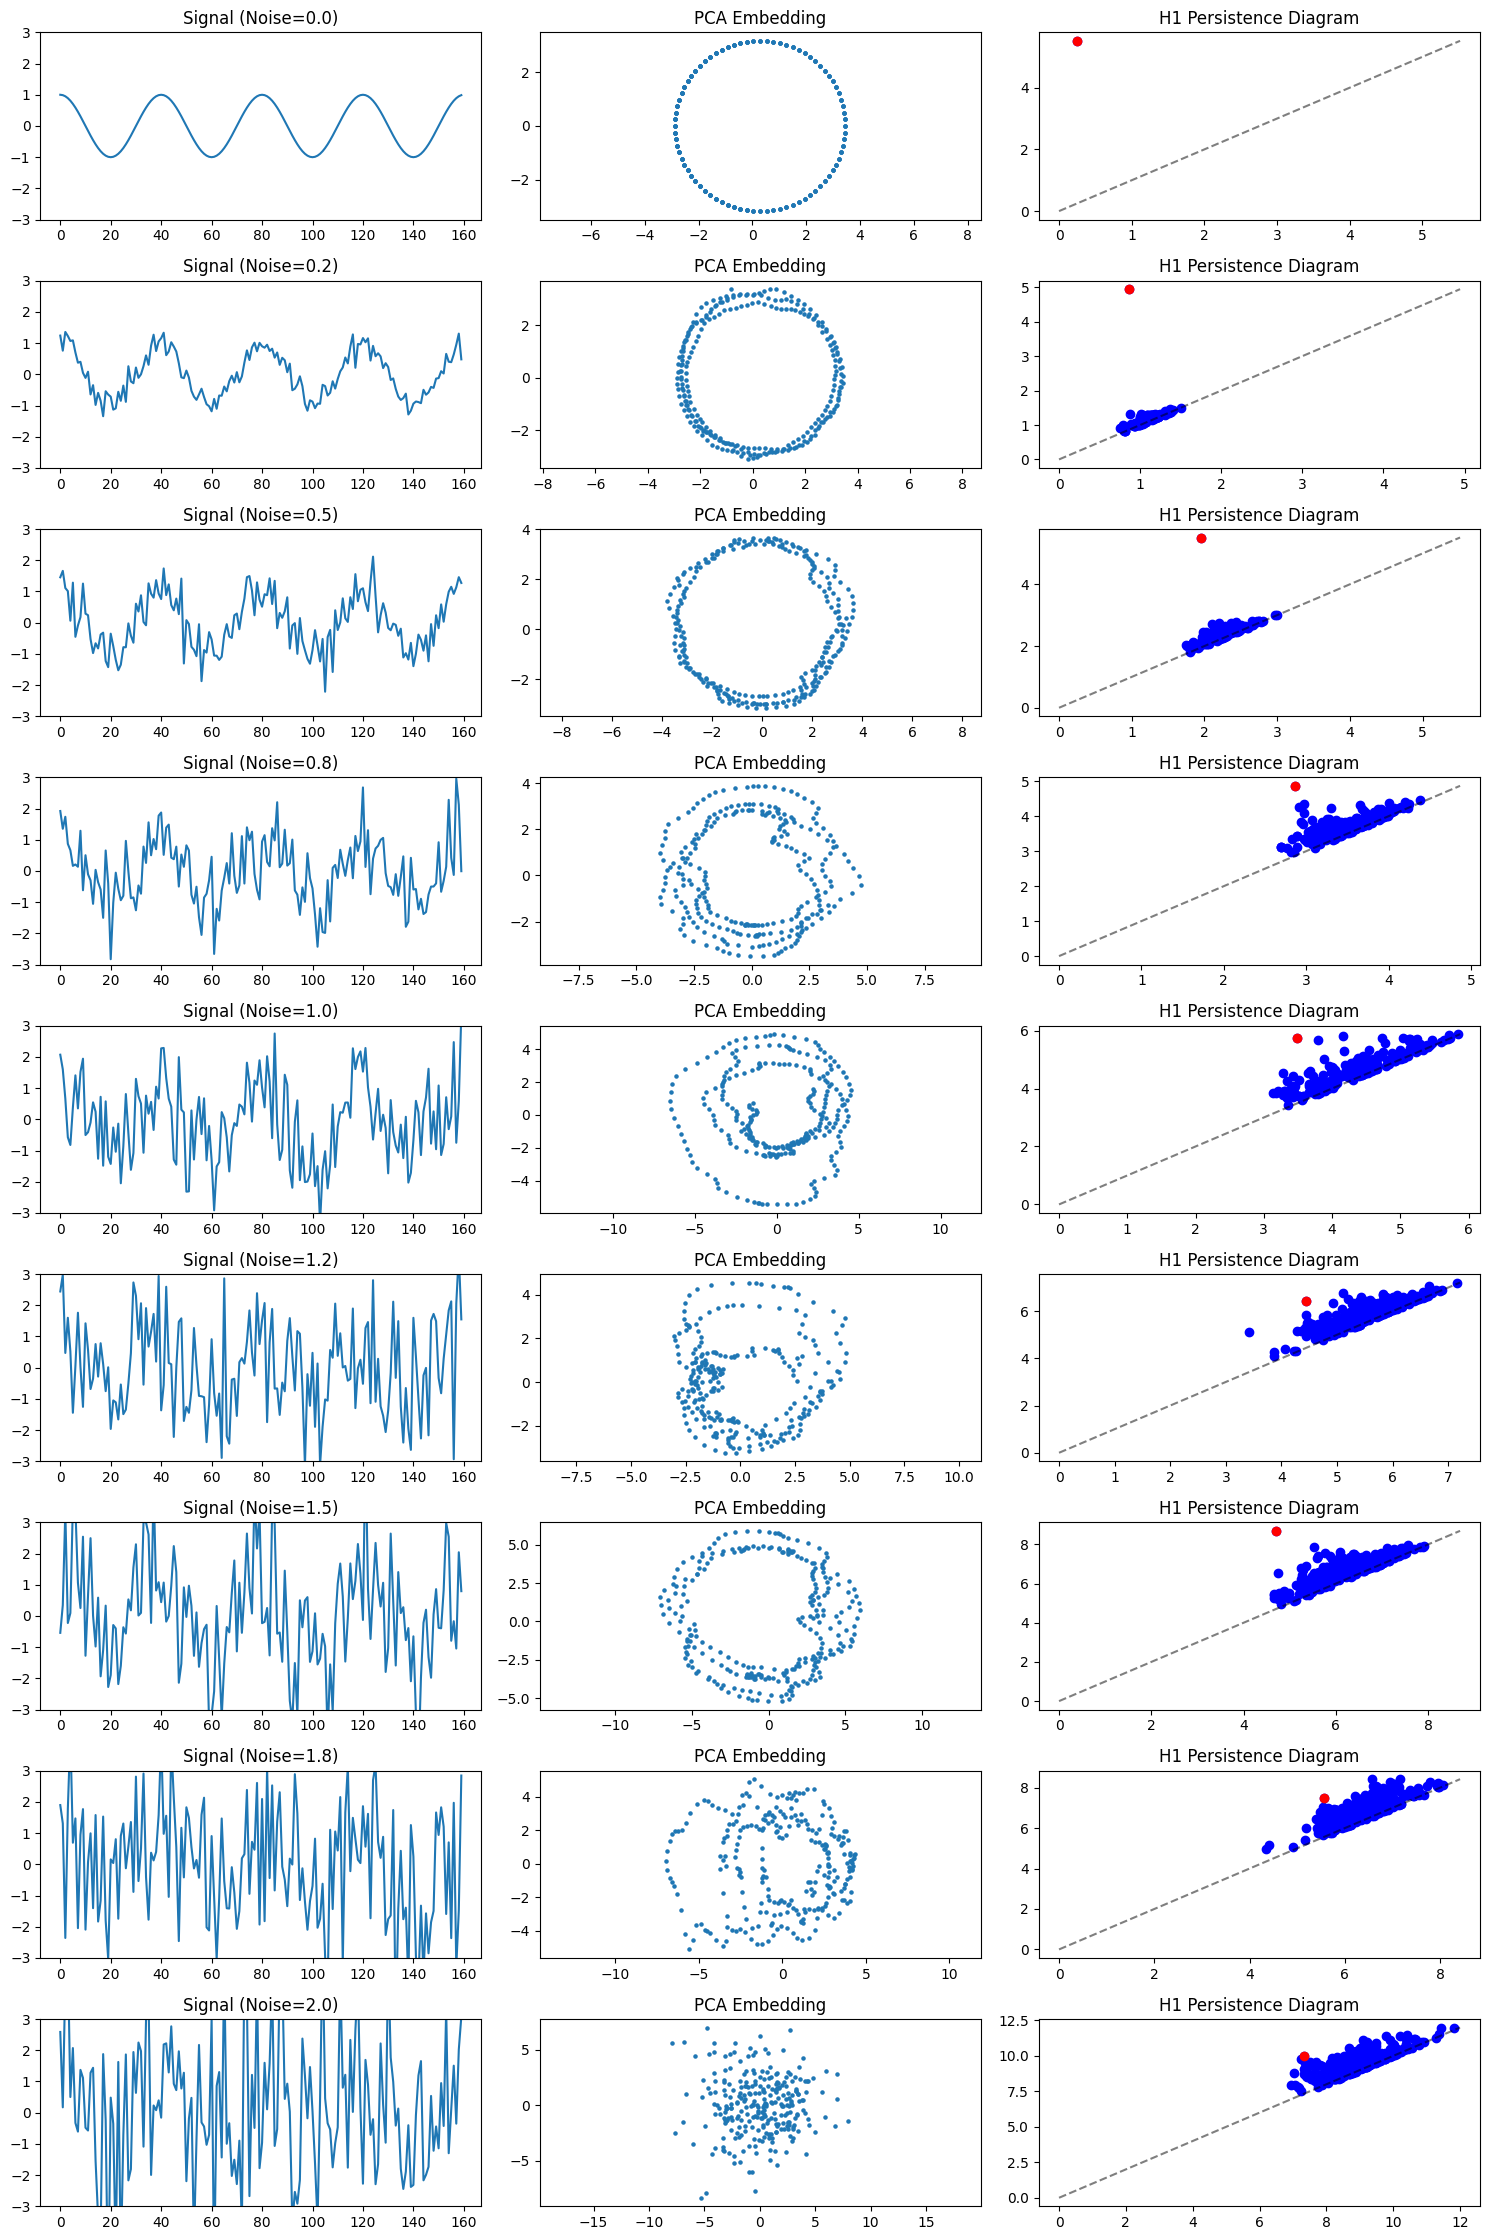

In [12]:
# Regenerate base signal and time
T = 40
NPeriods = 4
N = T * NPeriods
t = np.linspace(0, 2 * np.pi * NPeriods, N, endpoint=False)
signal_clean = np.cos(t)

# Settings
dim = 20
tau = 1.0
dT = 0.5
noise_levels = np.linspace(0, 2.0, 9)

# Track max persistences and PCA ratios
max_persist_by_noise = []
eig_ratios_by_noise = []

# Generate plots and compute persistence diagrams for different noise levels
fig, axs = plt.subplots(len(noise_levels), 3, figsize=(15, 2.5 * len(noise_levels)))

for i, noise_amp in enumerate(noise_levels):
    x = signal_clean + noise_amp * np.random.randn(len(signal_clean))
    X = getSlidingWindow(x, dim, tau, dT)

    # PCA for 2D projection
    pca = PCA(n_components=2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Ripser persistence diagram
    PDs = ripser(X, maxdim=1)['dgms']
    H1 = PDs[1]
    max_persistence = np.max(H1[:, 1] - H1[:, 0]) if len(H1) > 0 else 0

    max_persist_by_noise.append(max_persistence)
    eig_ratios_by_noise.append(eigs[1] / eigs[0] if eigs[0] != 0 else 0)

    # Plot signal
    axs[i, 0].plot(x)
    axs[i, 0].set_title(f"Signal (Noise={noise_amp:.1f})")
    axs[i, 0].set_ylim(-3, 3)

    # Plot PCA
    axs[i, 1].scatter(Y[:, 0], Y[:, 1], s=5)
    axs[i, 1].set_title(f"PCA Embedding")
    axs[i, 1].set_aspect('equal', 'datalim')

    # Plot persistence diagram
    axs[i, 2].scatter(H1[:, 0], H1[:, 1], c='blue')
    if len(H1) > 0:
        max_idx = np.argmax(H1[:, 1] - H1[:, 0])
        axs[i, 2].scatter(H1[max_idx, 0], H1[max_idx, 1], c='red')
    axs[i, 2].plot([0, np.max(H1)], [0, np.max(H1)], 'k--', alpha=0.5)
    axs[i, 2].set_title("H1 Persistence Diagram")

plt.tight_layout()
plt.show()